In [1]:
# Imports 
import os
import shutil
import kagglehub
from collections import Counter
import joblib

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy.stats import chi2_contingency, ttest_ind, mannwhitneyu
from statsmodels.stats.outliers_influence import variance_inflation_factor
from imblearn.over_sampling import SMOTE, ADASYN
from scipy.stats import randint, uniform

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

C:\Users\sofia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# # load the dataset as a pandas dataframe
# path = kagglehub.dataset_load(
#     KaggleDatasetAdapter.PANDAS,
#     "blastchar/telco-customer-churn",
#     path="telco-customer-churn.csv",
# )

# # Copy the dataset in data
# os.makedirs("data", exist_ok=True)
# shutil.copy(path, "data/telco-customer-churn.csv")

In [3]:
data = pd.read_csv("data/telco-customer-churn.csv", index_col="customerID")

## Data Cleaning

In [4]:
df = data.copy()
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
customerID,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
df.shape

(7043, 20)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   gender            7043 non-null   object 
 1   SeniorCitizen     7043 non-null   int64  
 2   Partner           7043 non-null   object 
 3   Dependents        7043 non-null   object 
 4   tenure            7043 non-null   int64  
 5   PhoneService      7043 non-null   object 
 6   MultipleLines     7043 non-null   object 
 7   InternetService   7043 non-null   object 
 8   OnlineSecurity    7043 non-null   object 
 9   OnlineBackup      7043 non-null   object 
 10  DeviceProtection  7043 non-null   object 
 11  TechSupport       7043 non-null   object 
 12  StreamingTV       7043 non-null   object 
 13  StreamingMovies   7043 non-null   object 
 14  Contract          7043 non-null   object 
 15  PaperlessBilling  7043 non-null   object 
 16  PaymentMethod     7043 non-null 

In [7]:
# Change type of TotalCharges to numeric, forcing errors to NaN
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# Get the summary statistics depending on the data type and number of nans in each column
def summary_statistics(df):
    for col in df.columns:
        if df[col].dtype == 'object':
            print(f"Categorical Column: {col}")
            print(df[col].value_counts())
        else:
            # if just 2 unique values, consider it categorical
            if df[col].nunique() <= 2:
                print(f"Boolean Column: {col}")
                print(df[col].value_counts())
            else:
                print(f"Numerical Column: {col}")
                print(df[col].describe())

        print("Number of missing values:")        
        print(df[col].isna().sum())
        print("\n")
        
summary_statistics(df)

Categorical Column: gender
Male      3555
Female    3488
Name: gender, dtype: int64
Number of missing values:
0


Boolean Column: SeniorCitizen
0    5901
1    1142
Name: SeniorCitizen, dtype: int64
Number of missing values:
0


Categorical Column: Partner
No     3641
Yes    3402
Name: Partner, dtype: int64
Number of missing values:
0


Categorical Column: Dependents
No     4933
Yes    2110
Name: Dependents, dtype: int64
Number of missing values:
0


Numerical Column: tenure
count    7043.000000
mean       32.371149
std        24.559481
min         0.000000
25%         9.000000
50%        29.000000
75%        55.000000
max        72.000000
Name: tenure, dtype: float64
Number of missing values:
0


Categorical Column: PhoneService
Yes    6361
No      682
Name: PhoneService, dtype: int64
Number of missing values:
0


Categorical Column: MultipleLines
No                  3390
Yes                 2971
No phone service     682
Name: MultipleLines, dtype: int64
Number of missing values:
0


C

In [8]:
# Include No phone service and No internet service as a category No
cols = ['MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies']
for col in cols:
    df[col] = df[col].replace({'No phone service': 'No', 'No internet service': 'No'})

# Check if TotalCharges is always greater than MonthlyCharges
print((df['TotalCharges'] < df['MonthlyCharges']).sum())

# Check if TotalCharges is egal to MonthlyCharges * Tenure
print((df['TotalCharges'] < df['MonthlyCharges'] * df['tenure']).sum())

# show the rows with missing values in TotalCharges
print(df[df['TotalCharges'].isna()])

# Drop rows with missing TotalCharges
df = df.dropna(subset=['TotalCharges'])

# Change SeniorCitizen to categorical
df['SeniorCitizen'] = df['SeniorCitizen'].replace({1: 'Yes', 0: 'No'})

0
3214
            gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
customerID                                                                  
4472-LVYGI  Female              0     Yes        Yes       0           No   
3115-CZMZD    Male              0      No        Yes       0          Yes   
5709-LVOEQ  Female              0     Yes        Yes       0          Yes   
4367-NUYAO    Male              0     Yes        Yes       0          Yes   
1371-DWPAZ  Female              0     Yes        Yes       0           No   
7644-OMVMY    Male              0     Yes        Yes       0          Yes   
3213-VVOLG    Male              0     Yes        Yes       0          Yes   
2520-SGTTA  Female              0     Yes        Yes       0          Yes   
2923-ARZLG    Male              0     Yes        Yes       0          Yes   
4075-WKNIU  Female              0     Yes        Yes       0          Yes   
2775-SEFEE    Male              0      No        Yes       0         

## Data Inspection

In [9]:
# Unbalanced target variable
print(df['Churn'].value_counts(normalize=True))

No     0.734215
Yes    0.265785
Name: Churn, dtype: float64


### Categorical Columns Analysis

#### *Visual Exploration*
We analyze categorical features' relationships with customer churn through:
- Distribution plots by churn status
- Bar plots showing proportions
- Count plots for frequency analysis
- Helps identify potential patterns visually

#### *Statistical Significance Testing*
We use Chi-Square test to evaluate relationships:

**Chi-Square Test of Independence**
   - Tests if categorical variables are independent of churn
   - Null hypothesis: No relationship exists
   - Alternative hypothesis: Variables are dependent
   - Significant if p-value < 0.05

**Interpretation**
- p-value < 0.05 : potential signaficant relationship
- p-value ≥ 0.05 : insignificant relationship

**Why This Matters**
- Identifies key categorical predictors of churn
- Guides feature engineering decisions

**Next Steps**
- Keep categories showing strong relationships
- Remove insignificant categorical variables

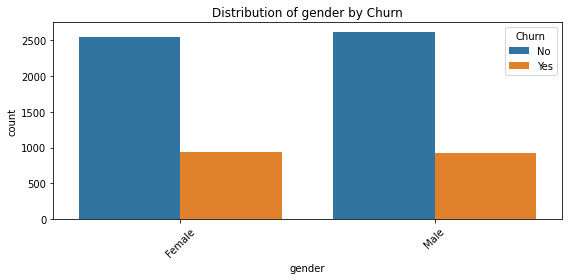

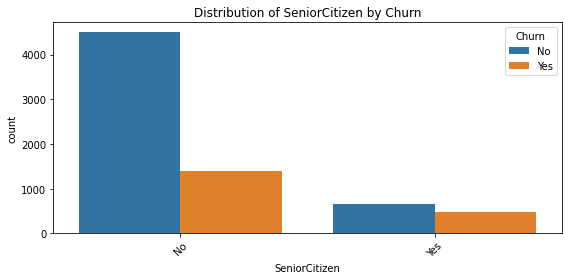

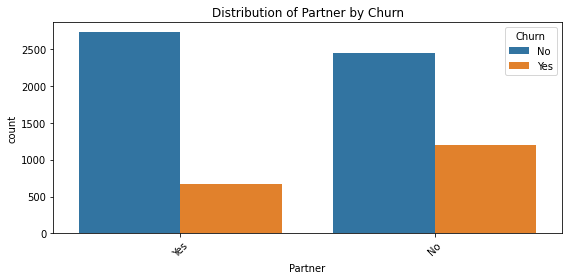

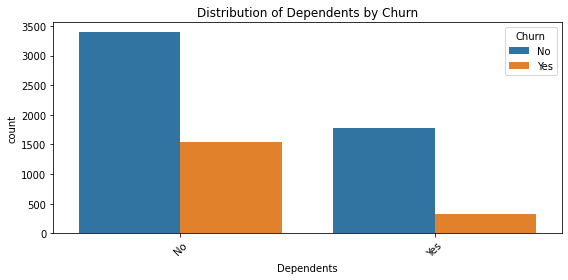

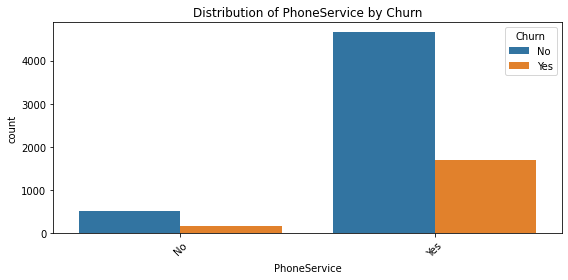

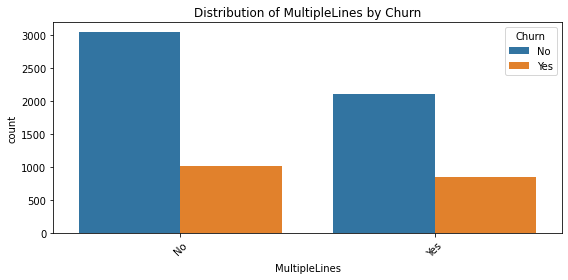

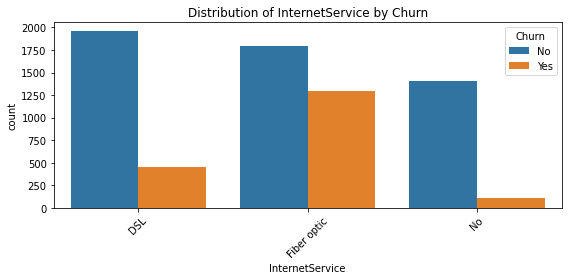

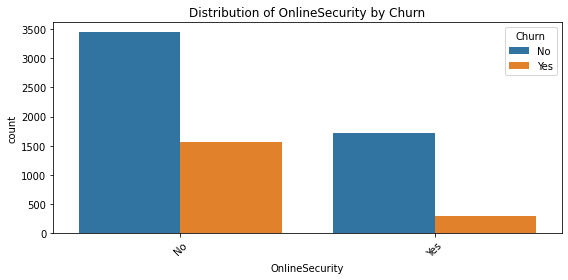

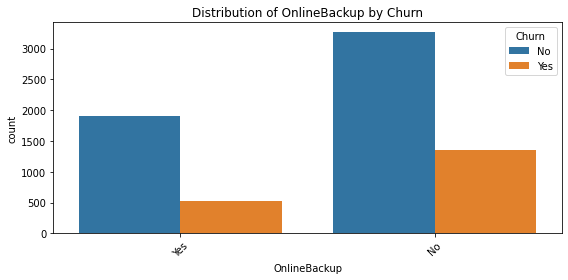

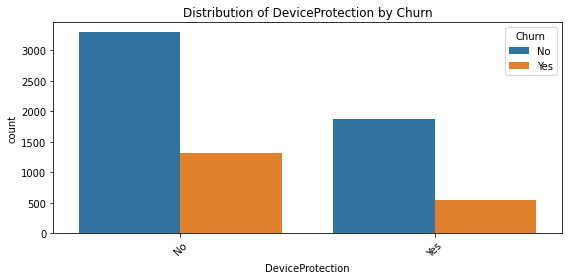

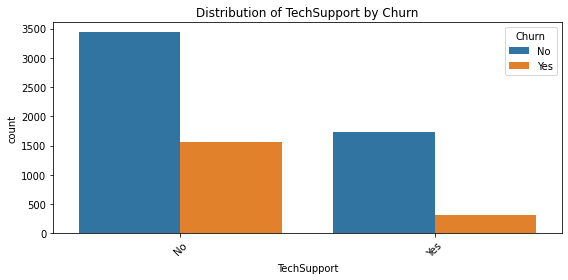

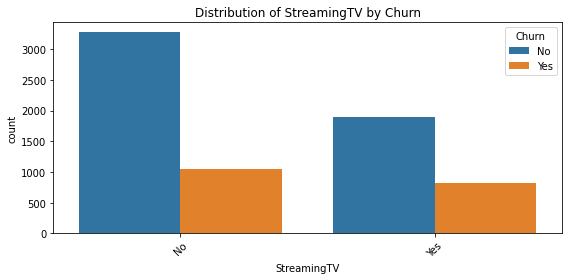

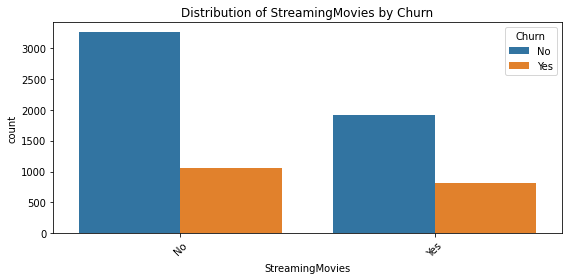

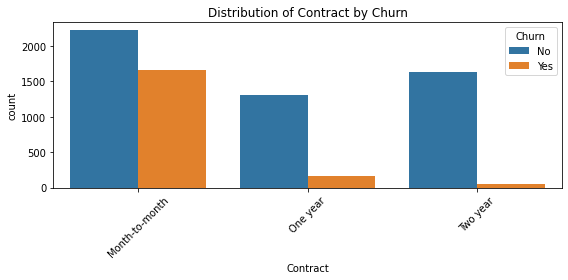

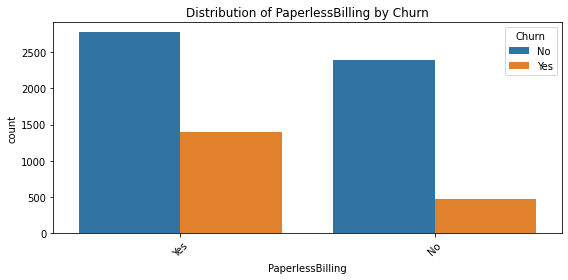

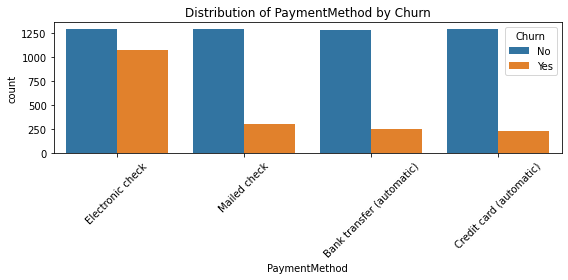

In [10]:
# Visualizations of categorical columns
categorical_cols = df.select_dtypes(include=['object']).columns.tolist()
categorical_cols.remove('Churn')  # Exclude target variable for now
for col in categorical_cols:
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df, x=col, hue='Churn')
    plt.title(f'Distribution of {col} by Churn')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

In [11]:
# Statistical tests for categorical columns to see if they are correlated with the target variable
# Using Chi-squared test if p-value > 0.05, the column is independent of the target variable
for col in categorical_cols:
    contingency_table = pd.crosstab(df[col], df['Churn'])
    chi2, p, dof, ex = chi2_contingency(contingency_table)
    print(f"Chi-squared test for {col}: p-value = {p}")

Chi-squared test for gender: p-value = 0.4904884707065509
Chi-squared test for SeniorCitizen: p-value = 2.4792557203954705e-36
Chi-squared test for Partner: p-value = 3.97379757451591e-36
Chi-squared test for Dependents: p-value = 2.0196592017051303e-42
Chi-squared test for PhoneService: p-value = 0.34992398942431924
Chi-squared test for MultipleLines: p-value = 0.0008694082815826175
Chi-squared test for InternetService: p-value = 5.831198962237274e-159
Chi-squared test for OnlineSecurity: p-value = 1.37424000884718e-46
Chi-squared test for OnlineBackup: p-value = 6.259257129714726e-12
Chi-squared test for DeviceProtection: p-value = 3.346074945648779e-08
Chi-squared test for TechSupport: p-value = 3.2328683255491206e-43
Chi-squared test for StreamingTV: p-value = 1.3164336109407092e-07
Chi-squared test for StreamingMovies: p-value = 3.857900347663822e-07
Chi-squared test for Contract: p-value = 7.326182186265472e-257
Chi-squared test for PaperlessBilling: p-value = 8.236203353962564e-

In [12]:
# Not use the following columns for modeling: gender, PhoneService
df = df.drop(columns=['gender', 'PhoneService'])

### Numerical data 
#### *Multcolinearity*
Multicollinearity occurs when two or more independent variables are highly correlated
- We use two methods to detect multicollinearity:
    1. Correlation Matrix: Shows pairwise correlations
    2. VIF (Variance Inflation Factor): Measures how much variance is inflated due to collinearity
- Guidelines:
    - Strong correlation: |r| > 0.7
    - VIF > 5-10 indicates problematic multicollinearity
- Why it matters:
    - Can make model unstable
    - Makes interpretation difficult
    - May reduce model accuracy

#### *Statistical Significance Analysis of Numerical Features*
We analyze the relationship between numerical features and customer churn using multiple statistical approaches:

1. **Parametric Test (T-test)**
   - Assumes normal distribution
   - Tests if means differ between churned and non-churned customers
   - Null hypothesis: No difference in means
   - Significant if p-value < 0.05

2. **Non-parametric Test (Mann-Whitney U)**
   - No assumption about distribution
   - Tests if distribution differs between groups
   - More robust for non-normal distributions
   - Significant if p-value < 0.05

3. **Visual Analysis**
   - Distribution plots by churn status
   - Box plots to identify differences and outliers
   - Helps validate statistical findings

**Interpretation**
- Strong Evidence: Feature is significant if both tests show p < 0.05
- Moderate Evidence: Feature is significant in one test only
- Weak Evidence: No significance in either test (p ≥ 0.05)

**Why This Matters**
- Helps identify which numerical features truly influence churn
- Reduces noise in the model by removing non-significant features
- Improves model interpretability and performance
- Guides feature selection decisions

**Next Steps**
- Keep features with strong evidence of significance
- Consider features with moderate evidence based on business context
- Remove features with weak evidence unless business logic suggests otherwise

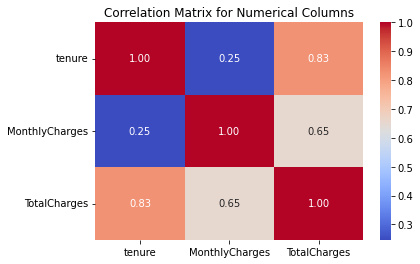

In [13]:
# Get correlation matrix for numerical columns 
numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
corr_matrix = df[numerical_cols].corr()
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix for Numerical Columns')
plt.show()

In [14]:
# Use VIF to check multicollinearity
# We keep columns with VIF < 5 in theory but we will consider a higher threshold if needed here 7 
X = df[numerical_cols]
vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
print(vif_data)

          feature       VIF
0          tenure  6.332432
1  MonthlyCharges  3.361075
2    TotalCharges  8.079181


In [15]:
# Select numeraical columns to keep based on statistical analysis
numerical_cols.remove('TotalCharges')  # High VIF

# apply t-test to see if the means of the numerical columns are significantly different between the two classes of the target variable
for col in numerical_cols:
    class_0 = df[df['Churn'] == 'No'][col]
    class_1 = df[df['Churn'] == 'Yes'][col]
    t_stat, p_value = ttest_ind(class_0, class_1)
    print(f"T-test for {col}: p-value = {p_value}")

T-test for tenure: p-value = 9.437650217574845e-207
T-test for MonthlyCharges: p-value = 6.760843117980302e-60


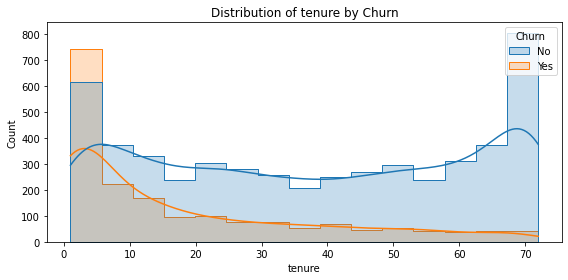

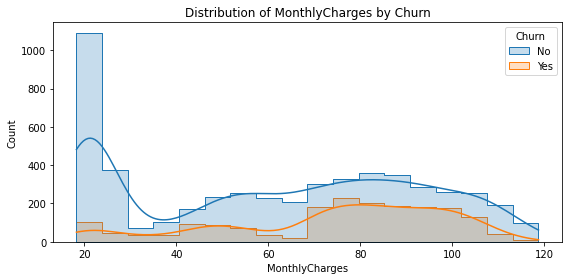

In [16]:
# Distribution of numerical columns
for col in numerical_cols:
    plt.figure(figsize=(8, 4))
    sns.histplot(data=df, x=col, hue='Churn', kde=True, element='step')
    plt.title(f'Distribution of {col} by Churn')
    plt.tight_layout()
    plt.show()

In [17]:
for col in numerical_cols:
    yes = df[df['Churn']=="Yes"][col]
    no = df[df['Churn']=="No"][col]

    stat, p = mannwhitneyu(yes, no)
    print(f"for {col} U-stat =", stat, "p-value =", p)

for tenure U-stat = 2494979.0 p-value = 6.043046580882717e-211
for MonthlyCharges U-stat = 5986148.5 p-value = 8.467195044548749e-54


## Preprocessing

1. Feature Selection Based on Statistical Tests
We apply results from our data inspection phase:
- **Categorical Features**: Remove features with
  - p-value > 0.05 in Chi-square test
  - Negligible/Weak Cramer's V association
- **Numerical Features**: Remove features with
  - High multicollinearity (VIF > 7)
  - Non-significant in both t-test and Mann-Whitney U test
  - Weak correlation with target variable

2. Class Imbalance Handling
We address the imbalanced target distribution using two oversampling methods:

    *SMOTE (Synthetic Minority Over-sampling Technique)*
    - Creates synthetic samples of minority class
    - Advantages:
        - Reduces overfitting compared to simple oversampling
        - Better generalization
        - More balanced decision regions

    *ADASYN (Adaptive Synthetic Sampling)*
    - Similar to SMOTE but focuses on harder-to-learn examples
    - Advantages:
        - Adaptive density distribution
        - More synthetic data for harder-to-learn cases
        - Reduces bias introduced by class imbalance

3. Data Validation
After resampling:
- Verify feature significance is maintained
- Check for any introduced anomalies
- Ensure data quality and relationships are preserved

In [18]:
# Apply needed preprocessing steps to data 
data = data.drop(columns=['TotalCharges', 'gender', 'PhoneService'])
print(data.duplicated().sum())
data = data.drop_duplicates()
data['Churn'] = data['Churn'].replace({'Yes': 1, 'No': 0})

58


In [19]:
# Get dummy variables for categorical columns
data = pd.get_dummies(data, drop_first=True)
data.head()

,SeniorCitizen,tenure,MonthlyCharges,Churn,Partner_Yes,Dependents_Yes,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,OnlineSecurity_No internet service,OnlineSecurity_Yes,OnlineBackup_No internet service,OnlineBackup_Yes,DeviceProtection_No internet service,DeviceProtection_Yes,TechSupport_No internet service,TechSupport_Yes,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaperlessBilling_Yes,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check
customerID,,,,,,,,,,,,,,,,,,,,,,,,,,,,
7590-VHVEG,0,1,29.85,0,1,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,1,0
5575-GNVDE,0,34,56.95,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1
3668-QPYBK,0,2,53.85,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1
7795-CFOCW,0,45,42.30,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0
9237-HQITU,0,2,70.70,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0


In [20]:
# Handle umbalanced target variable by oversampling the minority class Use Adasyn or SMOTE
X = data.drop(columns=['Churn'])
y = data['Churn']
print(f"Original class distribution: {Counter(y)}")

# Smote
smote = SMOTE(random_state=42)
X_res_smote, y_res_smote = smote.fit_resample(X, y)
print(f"Resampled class distribution SMOTE: {Counter(y_res_smote)}")

# Adasyn
adasyn = ADASYN(random_state=42)
X_res_adasyn, y_res_adasyn = adasyn.fit_resample(X, y)
print(f"Resampled class distribution ADASYN: {Counter(y_res_adasyn)}")

Original class distribution: Counter({0: 5140, 1: 1845})


C:\Users\sofia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


Resampled class distribution SMOTE: Counter({0: 5140, 1: 5140})
Resampled class distribution ADASYN: Counter({0: 5140, 1: 5078})


C:\Users\sofia\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.9_qbz5n2kfra8p0\LocalCache\local-packages\Python39\site-packages\sklearn\base.py:474: FutureWarning: `BaseEstimator._validate_data` is deprecated in 1.6 and will be removed in 1.7. Use `sklearn.utils.validation.validate_data` instead. This function becomes public and is part of the scikit-learn developer API.
  warnings.warn(


In [21]:
# Reuse statistical tests to check if the resampled data is still correlated with the target variable
data_res_smote = pd.concat([X_res_smote, y_res_smote], axis=1)
data_res_adasyn = pd.concat([X_res_adasyn, y_res_adasyn], axis=1)

new_categorical_cols = [col for col in data_res_smote.select_dtypes(include=['uint8']).columns if col != 'Churn']

dict_resampled = {'SMOTE': (data_res_smote, []) , 'ADASYN': (data_res_adasyn, [])}
for method, (dataset, cols_to_delete) in dict_resampled.items():
    print(f"\nStatistical tests for {method} resampled data:")
    for col in new_categorical_cols:
        contingency_table = pd.crosstab(dataset[col], dataset['Churn'])
        chi2, p, dof, ex = chi2_contingency(contingency_table)
        if p > 0.05:
            cols_to_delete.append(col)
        print(f"Chi-squared test for {col}: p-value = {p}")
    for col in numerical_cols:
        class_0 = dataset[dataset['Churn'] == 0][col]
        class_1 = dataset[dataset['Churn'] == 1][col]
        t_stat, p_value = mannwhitneyu(class_0, class_1)
        if p_value > 0.05:
            cols_to_delete.append(col)
        print(f"T-test for {col}: p-value = {p_value}")


Statistical tests for SMOTE resampled data:
Chi-squared test for Partner_Yes: p-value = 6.753731553634597e-186
Chi-squared test for Dependents_Yes: p-value = 1.2301242896799912e-199
Chi-squared test for MultipleLines_No phone service: p-value = 0.0004219446194393751
Chi-squared test for MultipleLines_Yes: p-value = 0.3663735641132603
Chi-squared test for InternetService_Fiber optic: p-value = 1.6499143714487665e-276
Chi-squared test for InternetService_No: p-value = 4.350451666541194e-205
Chi-squared test for OnlineSecurity_No internet service: p-value = 4.350451666541194e-205
Chi-squared test for OnlineSecurity_Yes: p-value = 1.611257207446553e-205
Chi-squared test for OnlineBackup_No internet service: p-value = 4.350451666541194e-205
Chi-squared test for OnlineBackup_Yes: p-value = 3.6340367929532096e-95
Chi-squared test for DeviceProtection_No internet service: p-value = 4.350451666541194e-205
Chi-squared test for DeviceProtection_Yes: p-value = 1.8898479657366174e-64
Chi-squared t

In [22]:
# Print columns to delete for each method
for method, (dataset, cols_to_delete) in dict_resampled.items():
    print(f"\nColumns to delete for {method} resampled data: {cols_to_delete}")


Columns to delete for SMOTE resampled data: ['MultipleLines_Yes', 'StreamingMovies_Yes']

Columns to delete for ADASYN resampled data: ['MultipleLines_No phone service', 'StreamingTV_Yes', 'StreamingMovies_Yes']


In [23]:
# Update data by removing the columns that are not correlated with the target variable
for method, (dataset, cols_to_delete) in dict_resampled.items():
    dataset.drop(columns=cols_to_delete, inplace=True)
    dict_resampled[method] = (dataset, cols_to_delete)

## Training Models

We evaluate multiple tree-based models for customer churn prediction:

### Model Selection
We chose tree-based models for their:
- Ability to handle non-linear relationships
- Built-in feature importance
- Robustness to outliers
- Strong performance on tabular data

### Models Overview

1. **RandomForest**
   - Ensemble of decision trees
   - Advantages:
     - Less prone to overfitting
     - Good feature importance insights
     - Handles missing values well

2. **XGBoost**
   - Gradient boosting implementation
   - Advantages:
     - High performance
     - Speed and efficiency
     - Regularization included

3. **CatBoost**
   - Specialized for categorical features
   - Advantages:
     - Handles categorical variables automatically(not used here cause for resampling we need numerical values)
     - Reduces overfitting
     - Good for imbalanced data

4. **LightGBM**
   - Light Gradient Boosting Machine
   - Advantages:
     - Faster training speed
     - Lower memory usage
     - Better accuracy on large datasets

### Evaluation Strategy
- Cross-validation with 5 folds
- Metrics:
  - F1-Score (primary metric)
  - Accuracy
  - Precision
  - Recall
  - ROC-AUC

### Validation Process
- Split: 80% training, 20% test
- Stratified sampling to maintain class distribution
- Independent evaluation for each resampling method (SMOTE/ADASYN)


Classification Report for RandomForest with SMOTE resampling:
              precision    recall  f1-score   support

           0       0.84      0.84      0.84      1028
           1       0.84      0.84      0.84      1028

    accuracy                           0.84      2056
   macro avg       0.84      0.84      0.84      2056
weighted avg       0.84      0.84      0.84      2056

Confusion Matrix:


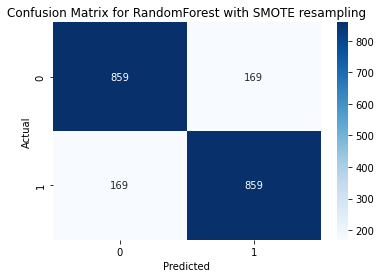


Classification Report for XGBoost with SMOTE resampling:
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      1028
           1       0.84      0.86      0.85      1028

    accuracy                           0.84      2056
   macro avg       0.84      0.84      0.84      2056
weighted avg       0.84      0.84      0.84      2056

Confusion Matrix:


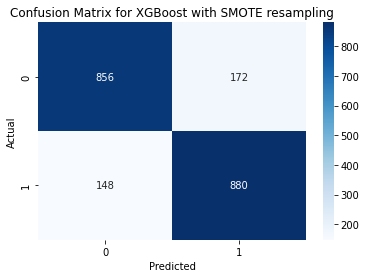


Classification Report for CatBoost with SMOTE resampling:
              precision    recall  f1-score   support

           0       0.85      0.82      0.83      1028
           1       0.82      0.86      0.84      1028

    accuracy                           0.84      2056
   macro avg       0.84      0.84      0.84      2056
weighted avg       0.84      0.84      0.84      2056

Confusion Matrix:


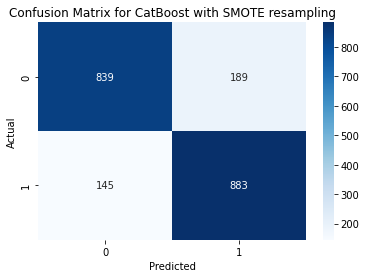

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3290, number of negative: 3289
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000528 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 374
[LightGBM] [Info] Number of data points in the train set: 6579, number of used features: 25
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500076 -> initscore=0.000304
[LightGBM] [Info] Start training from score 0.000304
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3290, number of negative: 3289
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000504 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=

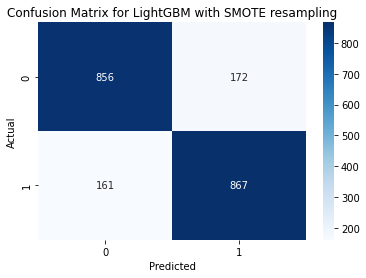


Classification Report for RandomForest with ADASYN resampling:
              precision    recall  f1-score   support

           0       0.83      0.82      0.82      1028
           1       0.82      0.83      0.83      1016

    accuracy                           0.83      2044
   macro avg       0.83      0.83      0.83      2044
weighted avg       0.83      0.83      0.83      2044

Confusion Matrix:


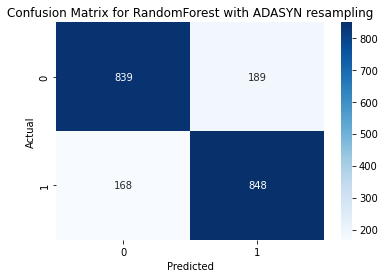


Classification Report for XGBoost with ADASYN resampling:
              precision    recall  f1-score   support

           0       0.86      0.81      0.83      1028
           1       0.82      0.86      0.84      1016

    accuracy                           0.84      2044
   macro avg       0.84      0.84      0.84      2044
weighted avg       0.84      0.84      0.84      2044

Confusion Matrix:


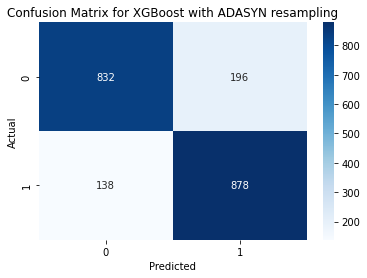


Classification Report for CatBoost with ADASYN resampling:
              precision    recall  f1-score   support

           0       0.86      0.80      0.83      1028
           1       0.81      0.87      0.84      1016

    accuracy                           0.84      2044
   macro avg       0.84      0.84      0.83      2044
weighted avg       0.84      0.84      0.83      2044

Confusion Matrix:


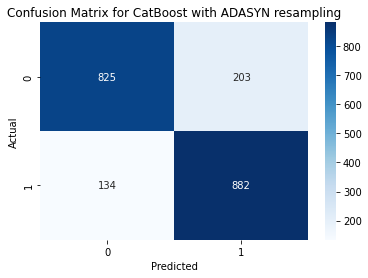

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3249, number of negative: 3290
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000744 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 372
[LightGBM] [Info] Number of data points in the train set: 6539, number of used features: 24
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.496865 -> initscore=-0.012540
[LightGBM] [Info] Start training from score -0.012540
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 3249, number of negative: 3290
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000717 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wis

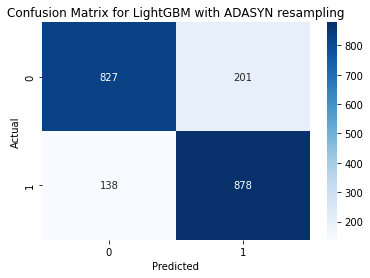

In [24]:
# define dict of models to train
models = {
    'RandomForest': RandomForestClassifier(random_state=42),
    'XGBoost': XGBClassifier(eval_metric='auc', random_state=42),
    'CatBoost': CatBoostClassifier(verbose=0, random_state=42),
    'LightGBM': LGBMClassifier(random_state=42)
}

# Get metrics dataframe
metrics_df = pd.DataFrame(columns=['Model', 'Resampling', 'CV_F1_Mean', 'CV_F1_Std', 'Test_Accuracy', 'Test_Precision', 'Test_Recall', 'Test_F1-Score', 'Test_ROC-AUC'])  

# Training Models using cross-validation
for method, (dataset, cols_to_delete) in dict_resampled.items():
    X = dataset.drop(columns=['Churn'])
    y = dataset['Churn']
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    for model_name, model in models.items():
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='f1')

        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]
        
        report = classification_report(y_test, y_pred, output_dict=True)
        accuracy = report['accuracy']
        precision = report['1']['precision']
        recall = report['1']['recall']
        f1_score = report['1']['f1-score']
        roc_auc = roc_auc_score(y_test, y_proba)

        # Print classification report and confusion matrix
        print(f"\nClassification Report for {model_name} with {method} resampling:")
        print(classification_report(y_test, y_pred))
        print("Confusion Matrix:")
        sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix for {model_name} with {method} resampling')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plt.show()
        
        metrics_df = metrics_df.append({
            'Model': model_name,
            'Resampling': method,
            'CV_F1_Mean': cv_scores.mean(),
            'CV_F1_Std': cv_scores.std(),
            'Test_Accuracy': accuracy,
            'Test_Precision': precision,
            'Test_Recall': recall,
            'Test_F1-Score': f1_score,
            'Test_ROC-AUC': roc_auc
        }, ignore_index=True)

In [25]:
metrics_df

,Model,Resampling,CV_F1_Mean,CV_F1_Std,Test_Accuracy,Test_Precision,Test_Recall,Test_F1-Score,Test_ROC-AUC
0,RandomForest,SMOTE,0.833208,0.005657,0.835603,0.835603,0.835603,0.835603,0.915806
1,XGBoost,SMOTE,0.833801,0.008925,0.844358,0.836502,0.856031,0.846154,0.914063
2,CatBoost,SMOTE,0.839208,0.009031,0.837549,0.823694,0.858949,0.840952,0.914627
3,LightGBM,SMOTE,0.837097,0.009883,0.838035,0.834456,0.843385,0.838897,0.915902
4,RandomForest,ADASYN,0.814710,0.003827,0.825342,0.817743,0.834646,0.826108,0.904381
5,XGBoost,ADASYN,0.831068,0.001657,0.836595,0.817505,0.864173,0.840191,0.908650
6,CatBoost,ADASYN,0.828786,0.007664,0.835127,0.812903,0.868110,0.839600,0.908890
7,LightGBM,ADASYN,0.829220,0.008440,0.834149,0.813716,0.864173,0.838186,0.909002


In [26]:
# The best model
best_model_info = metrics_df.sort_values(by='Test_F1-Score', ascending=False).iloc[0]
best_model_name = best_model_info['Model']
best_resampling_method = best_model_info['Resampling']
print(f"Best model: {best_model_name} with {best_resampling_method} resampling")

Best model: XGBoost with SMOTE resampling


In [27]:
# Fine-tune the best model XGBoost with SMOTE using RandomizedSearchCV
param_distributions = {
    'max_depth': randint(3, 10),
    'n_estimators': randint(100, 500),
    'learning_rate': uniform(0.01, 0.3)
}
random_search = RandomizedSearchCV(models[best_model_name], param_distributions, n_iter=10, scoring='f1', cv=5, random_state=42, n_jobs=-1)

# Fit the RandomizedSearchCV on the training data of the best resampling method
X = dict_resampled[best_resampling_method][0].drop(columns=['Churn'])
y = dict_resampled[best_resampling_method][0]['Churn']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_
print(f"Best hyperparameters: {random_search.best_params_}")
# Evaluate the best model on the test set
y_pred = best_model.predict(X_test)
y_proba = best_model.predict_proba(X_test)[:, 1]
print(f"\nClassification Report for the best model {best_model_name} after hyperparameter tuning:")
print(classification_report(y_test, y_pred))
# AUC-ROC
roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC-AUC: {roc_auc}")

Best hyperparameters: {'learning_rate': 0.22959818254342154, 'max_depth': 7, 'n_estimators': 120}

Classification Report for the best model XGBoost after hyperparameter tuning:
              precision    recall  f1-score   support

           0       0.85      0.83      0.84      1028
           1       0.84      0.85      0.84      1028

    accuracy                           0.84      2056
   macro avg       0.84      0.84      0.84      2056
weighted avg       0.84      0.84      0.84      2056

ROC-AUC: 0.9163329497797091


In [28]:
# Save the best model after RandomizedSearch
joblib.dump(best_model, 'best_model.pkl')

['best_model.pkl']